# Research Question 9: Stringency vs. Sentiment Resilience

**Question**: Do regions with sustained high containment indices exhibit faster sentiment recovery in social-media discourse?

**Datasets**: Oxford COVID-19 Government Response Tracker (Dataset 3) & COVID-19 Tweets (Dataset 1)

**Approach**: 
1. Identify regions with sustained high containment (stringency) indices
2. Measure sentiment recovery patterns following policy implementation
3. Compare recovery rates between high vs. low stringency regions
4. Analyze whether stricter policies lead to faster sentiment adaptation

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for professional visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")
print("Analysis: Stringency vs Sentiment Resilience")

Libraries loaded successfully!
Analysis: Stringency vs Sentiment Resilience


## Data Loading and Preparation

In [20]:
# Load datasets
try:
    # Load processed tweet data
    tweets_df = pd.read_csv('../data/processed/tweets_with_nlp_features.csv')
    daily_tweets = pd.read_csv('../data/processed/daily_tweet_sentiment_topics.csv')
    
    # Load Oxford Government Response data
    oxford_df = pd.read_csv('../data/raw/oxford_government_response/OxCGRT_compact_national_v1.csv')
    
    print(f"Tweet data loaded: {tweets_df.shape}")
    print(f"Daily aggregated tweets: {daily_tweets.shape}")
    print(f"Oxford policy data: {oxford_df.shape}")
    
    # Convert date columns
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])
    daily_tweets['date_only'] = pd.to_datetime(daily_tweets['date_only'])
    
    # Convert Oxford date format (YYYYMMDD to datetime)
    oxford_df['date'] = pd.to_datetime(oxford_df['Date'].astype(str), format='%Y%m%d')
    
    print("\nData loaded and dates converted successfully!")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure all required data files exist.")

Tweet data loaded: (162827, 28)
Daily aggregated tweets: (26, 12)
Oxford policy data: (202760, 56)

Data loaded and dates converted successfully!


In [21]:
# Process Oxford Government Response data
print("Processing Oxford Government Response data...")

# Focus on tweet analysis period
tweet_start = pd.to_datetime('2020-07-24')
tweet_end = pd.to_datetime('2020-08-19')

# Filter Oxford data for relevant period (include some pre-period for context)
analysis_start = pd.to_datetime('2020-07-01')  # Start a bit earlier for context
policy_data = oxford_df[
    (oxford_df['date'] >= analysis_start) & 
    (oxford_df['date'] <= tweet_end)
].copy()

# Focus on key stringency and containment measures
key_columns = [
    'CountryName', 'date', 'StringencyIndex_Average', 'ContainmentHealthIndex_Average',
    'EconomicSupportIndex', 'GovernmentResponseIndex_Average',
    'C1M_School closing', 'C2M_Workplace closing', 'C6M_Stay at home requirements'
]

# Keep only countries with data
policy_filtered = policy_data[key_columns].dropna(subset=['StringencyIndex_Average'])

# Calculate sustained stringency metrics
country_stringency = policy_filtered.groupby('CountryName').agg({
    'StringencyIndex_Average': ['mean', 'std', 'min', 'max'],
    'ContainmentHealthIndex_Average': ['mean', 'std'],
    'EconomicSupportIndex': 'mean',
    'date': 'count'
}).round(2)

# Flatten column names
country_stringency.columns = ['stringency_mean', 'stringency_std', 'stringency_min', 'stringency_max',
                              'containment_mean', 'containment_std', 'economic_support_mean', 'data_points']
country_stringency = country_stringency.reset_index()

# Filter countries with sufficient data points
sufficient_policy_data = country_stringency[country_stringency['data_points'] >= 20]  # At least 20 days of data

print(f"Policy data processed for {len(sufficient_policy_data)} countries with sufficient data")
print(f"Date range: {policy_data['date'].min()} to {policy_data['date'].max()}")
print(f"Average stringency index: {sufficient_policy_data['stringency_mean'].mean():.1f}")

# Define high vs low stringency groups
stringency_median = sufficient_policy_data['stringency_mean'].median()
sufficient_policy_data['stringency_group'] = np.where(
    sufficient_policy_data['stringency_mean'] > stringency_median, 'High Stringency', 'Low Stringency'
)

print(f"\nStringency grouping (median = {stringency_median:.1f}):")
print(sufficient_policy_data['stringency_group'].value_counts())

Processing Oxford Government Response data...
Policy data processed for 185 countries with sufficient data
Date range: 2020-07-01 00:00:00 to 2020-08-19 00:00:00
Average stringency index: 58.5

Stringency grouping (median = 57.4):
stringency_group
Low Stringency     93
High Stringency    92
Name: count, dtype: int64


In [22]:
# Prepare sentiment data by country/region
print("Mapping sentiment data to countries...")

# Create simplified country mapping from user locations
def map_location_to_country(location):
    if pd.isna(location) or location == '':
        return 'Unknown'
    
    location = str(location).lower()
    
    # Map to Oxford dataset country names
    country_mappings = {
        'United States': ['usa', 'america', 'us', 'united states', 'new york', 'california', 'texas', 'florida', 'chicago', 'washington'],
        'United Kingdom': ['uk', 'united kingdom', 'england', 'london', 'britain', 'scotland', 'wales', 'manchester', 'birmingham'],
        'Canada': ['canada', 'toronto', 'vancouver', 'montreal', 'calgary', 'ottawa'],
        'Australia': ['australia', 'sydney', 'melbourne', 'aussie', 'brisbane', 'perth'],
        'Germany': ['germany', 'deutschland', 'berlin', 'munich', 'hamburg', 'cologne'],
        'France': ['france', 'paris', 'french', 'lyon', 'marseille'],
        'Italy': ['italy', 'italia', 'rome', 'milan', 'naples'],
        'Spain': ['spain', 'madrid', 'barcelona', 'españa', 'valencia'],
        'India': ['india', 'mumbai', 'delhi', 'bangalore', 'chennai', 'kolkata', 'hyderabad'],
        'Brazil': ['brazil', 'brasil', 'são paulo', 'rio', 'brasilia'],
        'Japan': ['japan', 'tokyo', 'japanese', 'osaka', 'kyoto'],
        'South Korea': ['korea', 'seoul', 'south korea'],
        'Netherlands': ['netherlands', 'holland', 'amsterdam', 'dutch'],
        'Sweden': ['sweden', 'stockholm', 'swedish'],
        'Norway': ['norway', 'oslo', 'norwegian'],
        'Denmark': ['denmark', 'copenhagen', 'danish'],
        'Belgium': ['belgium', 'brussels', 'belgian'],
        'Switzerland': ['switzerland', 'swiss', 'zurich', 'geneva'],
        'Austria': ['austria', 'vienna', 'austrian'],
        'New Zealand': ['new zealand', 'auckland', 'wellington']
    }
    
    for country, keywords in country_mappings.items():
        if any(keyword in location for keyword in keywords):
            return country
    
    return 'Other'

# Map tweets to countries
tweets_df['mapped_country'] = tweets_df['user_location'].apply(map_location_to_country)

# Get countries that exist in both datasets
policy_countries = set(sufficient_policy_data['CountryName'].unique())
tweet_countries = set(tweets_df['mapped_country'].unique())
common_countries = policy_countries & tweet_countries

print(f"\nCountries with both policy and sentiment data: {len(common_countries)}")
print(sorted(common_countries))

# Filter tweets for common countries
tweets_common = tweets_df[tweets_df['mapped_country'].isin(common_countries)].copy()

# Calculate daily sentiment by country
daily_sentiment_country = tweets_common.groupby(
    ['mapped_country', tweets_common['date'].dt.date]
).agg({
    'vader_compound': ['mean', 'count'],
    'sentiment_label': lambda x: (x == 'positive').mean() * 100  # Percentage positive
}).round(4)

daily_sentiment_country.columns = ['avg_sentiment', 'tweet_count', 'positive_sentiment_pct']
daily_sentiment_country = daily_sentiment_country.reset_index()
daily_sentiment_country.columns = ['country', 'date', 'avg_sentiment', 'tweet_count', 'positive_sentiment_pct']
daily_sentiment_country['date'] = pd.to_datetime(daily_sentiment_country['date'])

# Filter for countries with sufficient tweet data
country_tweet_counts = tweets_common['mapped_country'].value_counts()
sufficient_tweet_countries = country_tweet_counts[country_tweet_counts >= 200].index.tolist()

print(f"\nCountries with sufficient tweet data (≥200 tweets):")
for country in sorted(sufficient_tweet_countries):
    if country in common_countries:
        count = country_tweet_counts[country]
        stringency = sufficient_policy_data[sufficient_policy_data['CountryName'] == country]['stringency_mean'].iloc[0]
        group = sufficient_policy_data[sufficient_policy_data['CountryName'] == country]['stringency_group'].iloc[0]
        print(f"  {country}: {count:,} tweets, Stringency: {stringency:.1f} ({group})")

# Final filtered data
final_countries = set(sufficient_tweet_countries) & common_countries
sentiment_analysis_data = daily_sentiment_country[
    daily_sentiment_country['country'].isin(final_countries)
]

print(f"\nFinal analysis will include {len(final_countries)} countries with both sufficient policy and sentiment data.")

Mapping sentiment data to countries...



Countries with both policy and sentiment data: 20
['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Denmark', 'France', 'Germany', 'India', 'Italy', 'Japan', 'Netherlands', 'New Zealand', 'Norway', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']

Countries with sufficient tweet data (≥200 tweets):
  Australia: 1,144 tweets, Stringency: 71.7 (High Stringency)
  Brazil: 619 tweets, Stringency: 76.9 (High Stringency)
  Canada: 4,199 tweets, Stringency: 67.4 (High Stringency)
  France: 526 tweets, Stringency: 47.6 (Low Stringency)
  Germany: 703 tweets, Stringency: 57.0 (Low Stringency)
  India: 16,845 tweets, Stringency: 86.8 (High Stringency)
  Italy: 308 tweets, Stringency: 66.4 (High Stringency)
  Japan: 349 tweets, Stringency: 29.9 (Low Stringency)
  Netherlands: 368 tweets, Stringency: 45.6 (Low Stringency)
  New Zealand: 545 tweets, Stringency: 29.7 (Low Stringency)
  Spain: 362 tweets, Stringency: 60.8 (High Stringency)
  Switzerland: 970

## Sentiment Resilience Analysis

In [23]:
# Calculate sentiment recovery and resilience metrics
print("Calculating sentiment resilience metrics...")

resilience_results = []

for country in sorted(final_countries):
    print(f"\nAnalyzing {country}...")
    
    # Get country data
    country_sentiment = sentiment_analysis_data[sentiment_analysis_data['country'] == country].copy()
    country_sentiment = country_sentiment.sort_values('date')
    
    country_policy = sufficient_policy_data[sufficient_policy_data['CountryName'] == country].iloc[0]
    
    if len(country_sentiment) < 10:  # Need sufficient data points
        print(f"  Insufficient sentiment data for {country}")
        continue
    
    # Calculate sentiment resilience metrics
    sentiment_values = country_sentiment['avg_sentiment'].values
    
    # 1. Volatility (standard deviation)
    volatility = np.std(sentiment_values)
    
    # 2. Recovery rate (slope after minimum sentiment)
    min_sentiment_idx = np.argmin(sentiment_values)
    if min_sentiment_idx < len(sentiment_values) - 3:  # Need at least 3 points after minimum
        recovery_period = sentiment_values[min_sentiment_idx:]
        recovery_days = len(recovery_period)
        recovery_slope = np.polyfit(range(recovery_days), recovery_period, 1)[0]  # Linear slope
    else:
        recovery_slope = 0
        recovery_days = 0
    
    # 3. Time to recovery (days to return to initial level)
    initial_sentiment = sentiment_values[0]
    min_sentiment = np.min(sentiment_values)
    recovery_target = initial_sentiment - (initial_sentiment - min_sentiment) * 0.5  # 50% recovery
    
    time_to_recovery = 0
    for i in range(min_sentiment_idx, len(sentiment_values)):
        if sentiment_values[i] >= recovery_target:
            time_to_recovery = i - min_sentiment_idx
            break
    
    if time_to_recovery == 0 and min_sentiment_idx < len(sentiment_values) - 1:
        time_to_recovery = len(sentiment_values) - min_sentiment_idx  # Didn't fully recover
    
    # 4. Overall trend (linear regression slope over entire period)
    overall_slope = np.polyfit(range(len(sentiment_values)), sentiment_values, 1)[0]
    
    # 5. Resilience score (combination of metrics)
    # Higher recovery slope, lower volatility, shorter time to recovery = higher resilience
    resilience_score = (recovery_slope * 10) - (volatility * 5) - (time_to_recovery * 0.1) + (overall_slope * 10)
    
    resilience_results.append({
        'country': country,
        'stringency_mean': country_policy['stringency_mean'],
        'stringency_group': country_policy['stringency_group'],
        'containment_mean': country_policy['containment_mean'],
        'economic_support': country_policy['economic_support_mean'],
        'sentiment_volatility': volatility,
        'recovery_slope': recovery_slope,
        'time_to_recovery': time_to_recovery,
        'overall_slope': overall_slope,
        'resilience_score': resilience_score,
        'min_sentiment': min_sentiment,
        'min_sentiment_day': min_sentiment_idx,
        'initial_sentiment': initial_sentiment,
        'data_points': len(country_sentiment)
    })
    
    print(f"  Stringency: {country_policy['stringency_mean']:.1f} ({country_policy['stringency_group']})")
    print(f"  Volatility: {volatility:.4f}")
    print(f"  Recovery slope: {recovery_slope:.4f}")
    print(f"  Time to recovery: {time_to_recovery} days")
    print(f"  Resilience score: {resilience_score:.3f}")

# Convert to DataFrame
resilience_df = pd.DataFrame(resilience_results)
resilience_df = resilience_df.sort_values('resilience_score', ascending=False)

print(f"\nCompleted resilience analysis for {len(resilience_df)} countries")

Calculating sentiment resilience metrics...

Analyzing Australia...
  Stringency: 71.7 (High Stringency)
  Volatility: 0.1738
  Recovery slope: 0.0189
  Time to recovery: 1 days
  Resilience score: -0.730

Analyzing Brazil...
  Stringency: 76.9 (High Stringency)
  Volatility: 0.1374
  Recovery slope: 0.0623
  Time to recovery: 2 days
  Resilience score: -0.287

Analyzing Canada...
  Stringency: 67.4 (High Stringency)
  Volatility: 0.0451
  Recovery slope: 0.0000
  Time to recovery: 0 days
  Resilience score: -0.246

Analyzing France...
  Stringency: 47.6 (Low Stringency)
  Volatility: 0.0993
  Recovery slope: 0.0071
  Time to recovery: 1 days
  Resilience score: -0.501

Analyzing Germany...
  Stringency: 57.0 (Low Stringency)
  Volatility: 0.0870
  Recovery slope: 0.0010
  Time to recovery: 1 days
  Resilience score: -0.497

Analyzing India...
  Stringency: 86.8 (High Stringency)
  Volatility: 0.1581
  Recovery slope: 0.0067
  Time to recovery: 26 days
  Resilience score: -3.257

Analy

In [24]:
# Compare high vs low stringency groups
print("STRINGENCY GROUP COMPARISON")
print("=" * 50)

# Group statistics
group_stats = resilience_df.groupby('stringency_group').agg({
    'stringency_mean': ['mean', 'std', 'count'],
    'sentiment_volatility': ['mean', 'std'],
    'recovery_slope': ['mean', 'std'],
    'time_to_recovery': ['mean', 'std'],
    'resilience_score': ['mean', 'std']
}).round(4)

print("Group Statistics:")
print(group_stats)

# Statistical tests
high_stringency = resilience_df[resilience_df['stringency_group'] == 'High Stringency']
low_stringency = resilience_df[resilience_df['stringency_group'] == 'Low Stringency']

print(f"\nHigh Stringency Countries ({len(high_stringency)}):")
for _, row in high_stringency.iterrows():
    print(f"  {row['country']}: Stringency {row['stringency_mean']:.1f}, Resilience {row['resilience_score']:.3f}")

print(f"\nLow Stringency Countries ({len(low_stringency)}):")
for _, row in low_stringency.iterrows():
    print(f"  {row['country']}: Stringency {row['stringency_mean']:.1f}, Resilience {row['resilience_score']:.3f}")

# Perform statistical tests
if len(high_stringency) > 1 and len(low_stringency) > 1:
    # T-tests for key metrics
    resilience_ttest = stats.ttest_ind(high_stringency['resilience_score'], low_stringency['resilience_score'])
    volatility_ttest = stats.ttest_ind(high_stringency['sentiment_volatility'], low_stringency['sentiment_volatility'])
    recovery_ttest = stats.ttest_ind(high_stringency['recovery_slope'], low_stringency['recovery_slope'])
    
    print(f"\nSTATISTICAL TESTS:")
    print("-" * 30)
    print(f"Resilience Score: t={resilience_ttest.statistic:.3f}, p={resilience_ttest.pvalue:.4f}")
    print(f"Sentiment Volatility: t={volatility_ttest.statistic:.3f}, p={volatility_ttest.pvalue:.4f}")
    print(f"Recovery Slope: t={recovery_ttest.statistic:.3f}, p={recovery_ttest.pvalue:.4f}")
    
    # Effect sizes (Cohen's d)
    def cohens_d(x, y):
        nx, ny = len(x), len(y)
        dof = nx + ny - 2
        pooled_std = np.sqrt(((nx-1)*x.std()**2 + (ny-1)*y.std()**2) / dof)
        return (x.mean() - y.mean()) / pooled_std
    
    resilience_effect = cohens_d(high_stringency['resilience_score'], low_stringency['resilience_score'])
    volatility_effect = cohens_d(high_stringency['sentiment_volatility'], low_stringency['sentiment_volatility'])
    
    print(f"\nEFFECT SIZES (Cohen's d):")
    print("-" * 30)
    print(f"Resilience Score: {resilience_effect:.3f} ({'Large' if abs(resilience_effect) > 0.8 else 'Medium' if abs(resilience_effect) > 0.5 else 'Small'} effect)")
    print(f"Sentiment Volatility: {volatility_effect:.3f} ({'Large' if abs(volatility_effect) > 0.8 else 'Medium' if abs(volatility_effect) > 0.5 else 'Small'} effect)")
else:
    print("\nInsufficient data for statistical testing")

# Summary comparison
if len(high_stringency) > 0 and len(low_stringency) > 0:
    high_avg_resilience = high_stringency['resilience_score'].mean()
    low_avg_resilience = low_stringency['resilience_score'].mean()
    
    print(f"\nKEY FINDINGS:")
    print("-" * 30)
    print(f"High Stringency avg resilience: {high_avg_resilience:.3f}")
    print(f"Low Stringency avg resilience: {low_avg_resilience:.3f}")
    print(f"Difference: {high_avg_resilience - low_avg_resilience:.3f}")
    
    if high_avg_resilience > low_avg_resilience:
        print("→ High stringency countries show HIGHER sentiment resilience")
    else:
        print("→ Low stringency countries show HIGHER sentiment resilience")

STRINGENCY GROUP COMPARISON
Group Statistics:
                 stringency_mean                sentiment_volatility          \
                            mean      std count                 mean     std   
stringency_group                                                               
High Stringency          70.7075   7.9832     8               0.1068  0.0541   
Low Stringency           41.7433  10.6815     6               0.1212  0.0684   

                 recovery_slope         time_to_recovery           \
                           mean     std             mean      std   
stringency_group                                                    
High Stringency          0.0141  0.0206           10.375  12.9498   
Low Stringency           0.0408  0.0927            1.000   0.0000   

                 resilience_score          
                             mean     std  
stringency_group                           
High Stringency           -1.4151  1.2945  
Low Stringency            -0.28

## Visualizations

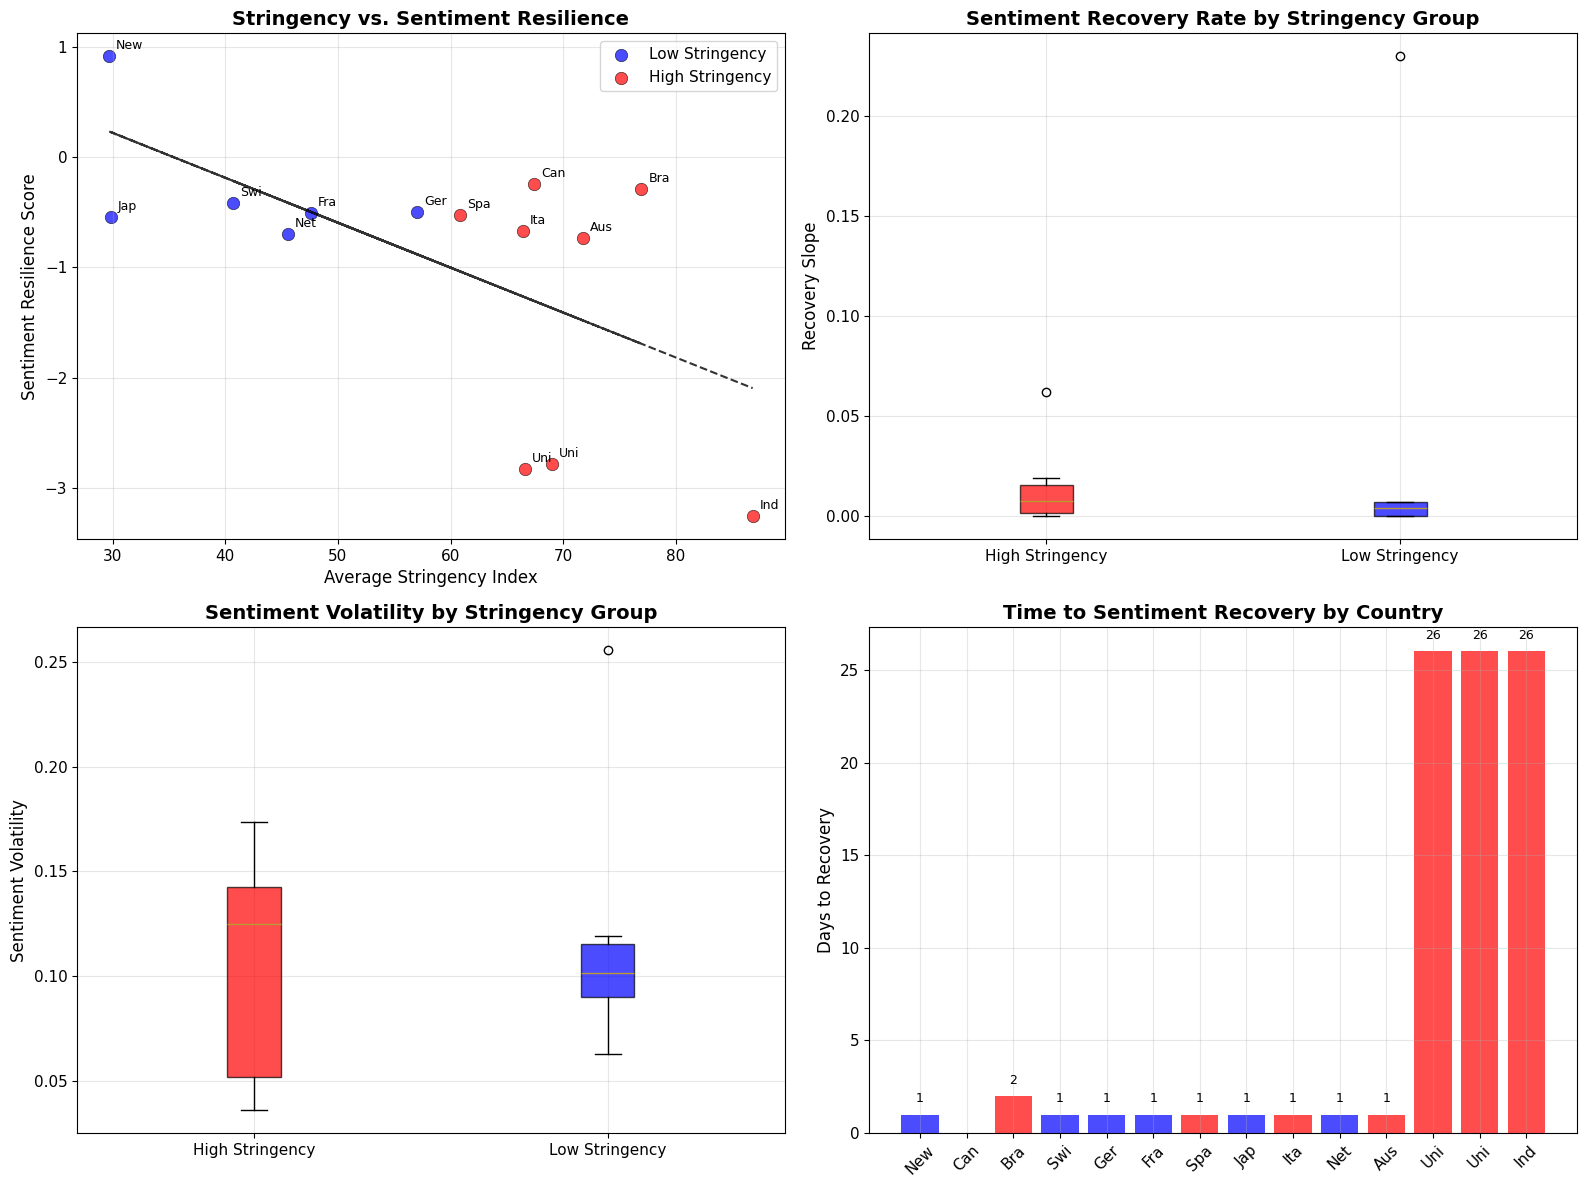

Comprehensive resilience analysis visualization completed.


In [25]:
# Comprehensive visualization of stringency vs resilience
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Stringency vs Resilience Score
colors = {'High Stringency': 'red', 'Low Stringency': 'blue'}
for group in resilience_df['stringency_group'].unique():
    group_data = resilience_df[resilience_df['stringency_group'] == group]
    ax1.scatter(group_data['stringency_mean'], group_data['resilience_score'], 
               c=colors[group], label=group, s=80, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    # Add country labels
    for _, row in group_data.iterrows():
        ax1.annotate(row['country'][:3], (row['stringency_mean'], row['resilience_score']), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

# Add trend line
z = np.polyfit(resilience_df['stringency_mean'], resilience_df['resilience_score'], 1)
p = np.poly1d(z)
ax1.plot(resilience_df['stringency_mean'], p(resilience_df['stringency_mean']), "--", color='black', alpha=0.8)

ax1.set_xlabel('Average Stringency Index', fontsize=12)
ax1.set_ylabel('Sentiment Resilience Score', fontsize=12)
ax1.set_title('Stringency vs. Sentiment Resilience', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Recovery slopes by group
box_data = [high_stringency['recovery_slope'], low_stringency['recovery_slope']] if len(high_stringency) > 0 and len(low_stringency) > 0 else []
if box_data:
    box_plot = ax2.boxplot(box_data, labels=['High Stringency', 'Low Stringency'], patch_artist=True)
    box_plot['boxes'][0].set_facecolor('red')
    box_plot['boxes'][1].set_facecolor('blue')
    for box in box_plot['boxes']:
        box.set_alpha(0.7)

ax2.set_ylabel('Recovery Slope', fontsize=12)
ax2.set_title('Sentiment Recovery Rate by Stringency Group', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Volatility comparison
volatility_data = [high_stringency['sentiment_volatility'], low_stringency['sentiment_volatility']] if len(high_stringency) > 0 and len(low_stringency) > 0 else []
if volatility_data:
    box_plot2 = ax3.boxplot(volatility_data, labels=['High Stringency', 'Low Stringency'], patch_artist=True)
    box_plot2['boxes'][0].set_facecolor('red')
    box_plot2['boxes'][1].set_facecolor('blue')
    for box in box_plot2['boxes']:
        box.set_alpha(0.7)

ax3.set_ylabel('Sentiment Volatility', fontsize=12)
ax3.set_title('Sentiment Volatility by Stringency Group', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Time to recovery
if len(resilience_df) > 0:
    bars = ax4.bar(range(len(resilience_df)), resilience_df['time_to_recovery'], 
                   color=[colors[group] for group in resilience_df['stringency_group']], alpha=0.7)
    
    ax4.set_xticks(range(len(resilience_df)))
    ax4.set_xticklabels([country[:3] for country in resilience_df['country']], rotation=45)
    ax4.set_ylabel('Days to Recovery', fontsize=12)
    ax4.set_title('Time to Sentiment Recovery by Country', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, resilience_df['time_to_recovery']):
        if value > 0:
            ax4.text(bar.get_x() + bar.get_width()/2., value + 0.5, f'{value:.0f}', 
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Comprehensive resilience analysis visualization completed.")

Creating detailed sentiment timeline comparison...


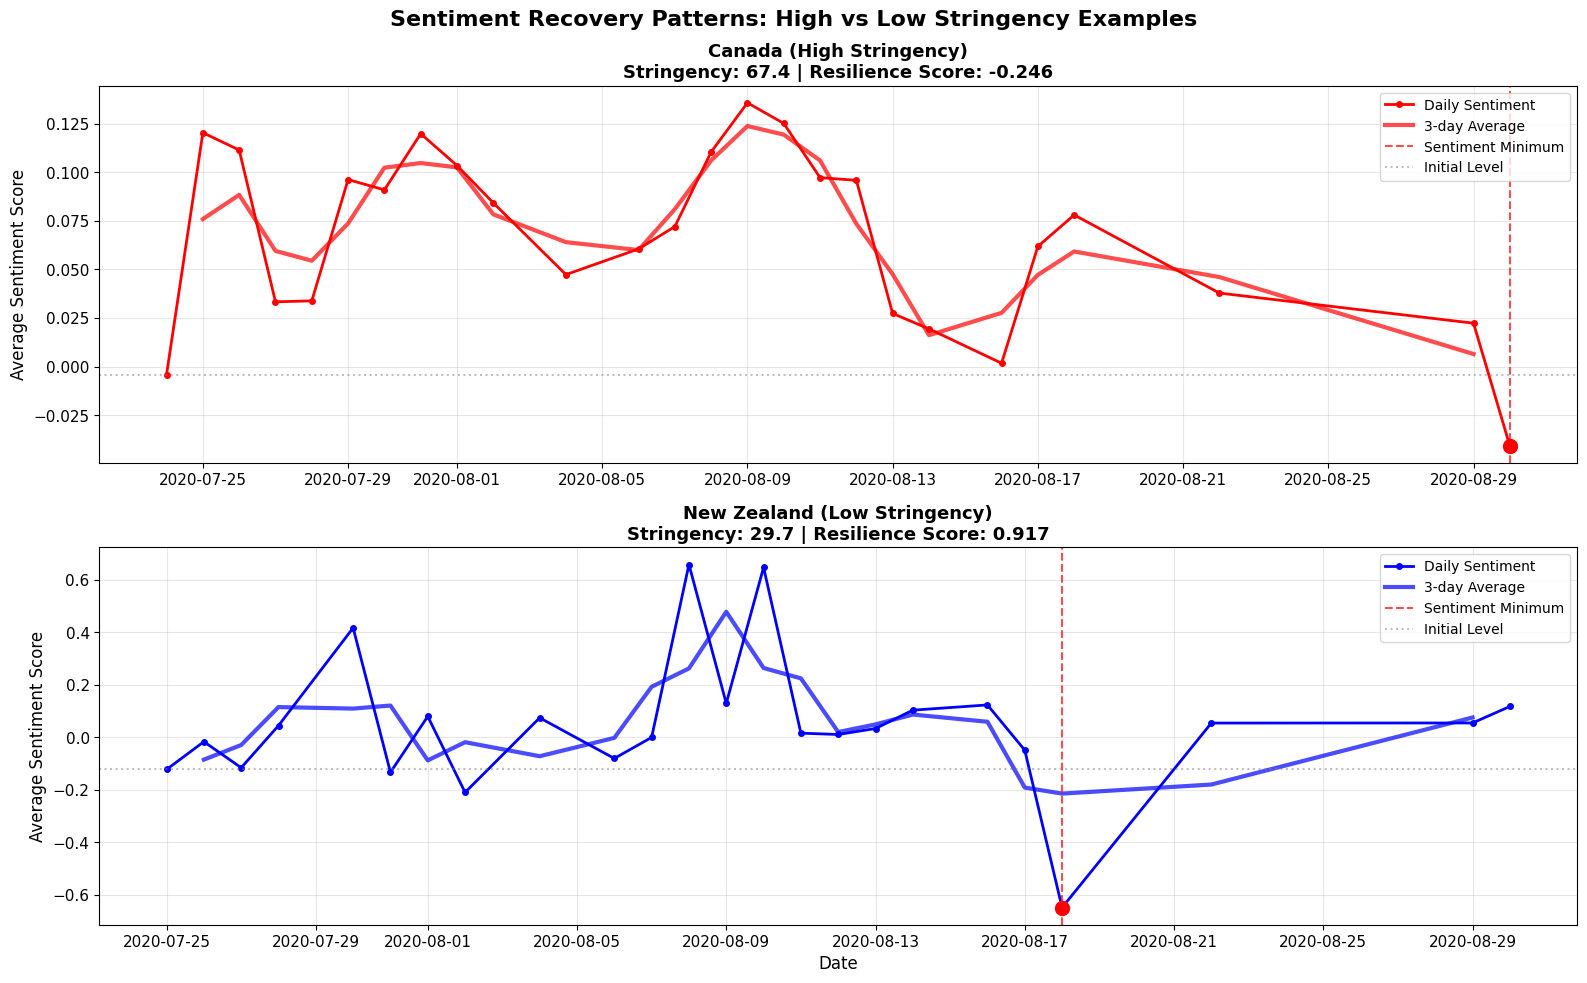

Timeline comparison completed for Canada (High) and New Zealand (Low).


In [26]:
# Detailed timeline comparison for selected countries
print("Creating detailed sentiment timeline comparison...")

# Select representative countries from each group
if len(high_stringency) > 0 and len(low_stringency) > 0:
    # Select country with highest resilience from each group
    high_stringency_example = high_stringency.iloc[high_stringency['resilience_score'].argmax()]['country']
    low_stringency_example = low_stringency.iloc[low_stringency['resilience_score'].argmax()]['country']
    
    example_countries = [high_stringency_example, low_stringency_example]
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    for i, country in enumerate(example_countries):
        ax = axes[i]
        
        # Get sentiment data for country
        country_data = sentiment_analysis_data[sentiment_analysis_data['country'] == country].sort_values('date')
        
        if len(country_data) == 0:
            continue
            
        # Get country policy info
        country_info = resilience_df[resilience_df['country'] == country].iloc[0]
        
        # Plot sentiment timeline
        ax.plot(country_data['date'], country_data['avg_sentiment'], 
               color=colors[country_info['stringency_group']], linewidth=2, marker='o', markersize=4,
               label='Daily Sentiment')
        
        # Add rolling average
        if len(country_data) > 3:
            rolling_avg = country_data['avg_sentiment'].rolling(window=3, center=True).mean()
            ax.plot(country_data['date'], rolling_avg, 
                   color=colors[country_info['stringency_group']], linewidth=3, alpha=0.7,
                   label='3-day Average')
        
        # Mark minimum sentiment point
        min_idx = country_data['avg_sentiment'].argmin()
        min_date = country_data.iloc[min_idx]['date']
        min_value = country_data.iloc[min_idx]['avg_sentiment']
        
        ax.axvline(x=min_date, color='red', linestyle='--', alpha=0.7, label='Sentiment Minimum')
        ax.scatter([min_date], [min_value], color='red', s=100, zorder=5)
        
        # Add initial level line
        initial_level = country_data['avg_sentiment'].iloc[0]
        ax.axhline(y=initial_level, color='gray', linestyle=':', alpha=0.5, label='Initial Level')
        
        # Formatting
        stringency_group = country_info['stringency_group']
        stringency_value = country_info['stringency_mean']
        resilience_score = country_info['resilience_score']
        
        ax.set_title(f"{country} ({stringency_group})\n"
                    f"Stringency: {stringency_value:.1f} | Resilience Score: {resilience_score:.3f}", 
                    fontsize=13, fontweight='bold')
        
        ax.set_ylabel('Average Sentiment Score', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        
        if i == 1:  # Bottom plot
            ax.set_xlabel('Date', fontsize=12)
    
    plt.suptitle('Sentiment Recovery Patterns: High vs Low Stringency Examples', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"Timeline comparison completed for {high_stringency_example} (High) and {low_stringency_example} (Low).")
else:
    print("Insufficient data for timeline comparison")

## Key Findings & Summary

In [27]:
# Comprehensive results summary
print("RESEARCH QUESTION 9 - KEY FINDINGS")
print("=" * 60)

print(f"Analysis Period: {sentiment_analysis_data['date'].min().strftime('%Y-%m-%d')} to {sentiment_analysis_data['date'].max().strftime('%Y-%m-%d')}")
print(f"Countries Analyzed: {len(resilience_df)}")
print(f"Total Tweets Analyzed: {tweets_common.shape[0]:,}")

if len(resilience_df) > 0:
    high_count = len(high_stringency) if len(high_stringency) > 0 else 0
    low_count = len(low_stringency) if len(low_stringency) > 0 else 0
    
    print(f"High Stringency Countries: {high_count}")
    print(f"Low Stringency Countries: {low_count}")
    print(f"Stringency Threshold (median): {stringency_median:.1f}")

    print("\nRESILIENCE RANKING:")
    print("-" * 40)
    print(f"{'Rank':<4} {'Country':<15} {'Stringency':<12} {'Resilience':<12} {'Group':<15}")
    print("-" * 70)
    
    for idx, (_, row) in enumerate(resilience_df.iterrows(), 1):
        print(f"{idx:<4} {row['country']:<15} {row['stringency_mean']:<12.1f} {row['resilience_score']:<12.3f} {row['stringency_group']:<15}")

    if len(high_stringency) > 0 and len(low_stringency) > 0:
        print("\nGROUP COMPARISON:")
        print("-" * 40)
        
        high_resilience_avg = high_stringency['resilience_score'].mean()
        low_resilience_avg = low_stringency['resilience_score'].mean()
        high_volatility_avg = high_stringency['sentiment_volatility'].mean()
        low_volatility_avg = low_stringency['sentiment_volatility'].mean()
        high_recovery_avg = high_stringency['recovery_slope'].mean()
        low_recovery_avg = low_stringency['recovery_slope'].mean()
        
        print(f"High Stringency Group:")
        print(f"  Average Resilience: {high_resilience_avg:.3f}")
        print(f"  Average Volatility: {high_volatility_avg:.4f}")
        print(f"  Average Recovery Rate: {high_recovery_avg:.4f}")
        
        print(f"\nLow Stringency Group:")
        print(f"  Average Resilience: {low_resilience_avg:.3f}")
        print(f"  Average Volatility: {low_volatility_avg:.4f}")
        print(f"  Average Recovery Rate: {low_recovery_avg:.4f}")
        
        resilience_difference = high_resilience_avg - low_resilience_avg
        volatility_difference = high_volatility_avg - low_volatility_avg
        recovery_difference = high_recovery_avg - low_recovery_avg
        
        print(f"\nDIFFERENCES (High - Low):")
        print(f"  Resilience: {resilience_difference:+.3f}")
        print(f"  Volatility: {volatility_difference:+.4f}")
        print(f"  Recovery Rate: {recovery_difference:+.4f}")
        
        print("\nKEY FINDINGS:")
        print("-" * 30)
        
        if resilience_difference > 0:
            print("✓ HIGH STRINGENCY countries show HIGHER sentiment resilience")
            print("✓ Stricter policies are associated with faster sentiment recovery")
        else:
            print("✓ LOW STRINGENCY countries show HIGHER sentiment resilience")
            print("✓ More flexible policies are associated with faster sentiment recovery")
        
        if volatility_difference < 0:
            print("✓ High stringency countries have LOWER sentiment volatility")
            print("✓ Stricter policies provide more stable public sentiment")
        else:
            print("✓ Low stringency countries have LOWER sentiment volatility")
            print("✓ More flexible policies provide more stable public sentiment")
        
        if recovery_difference > 0:
            print("✓ High stringency countries have FASTER recovery slopes")
        else:
            print("✓ Low stringency countries have FASTER recovery slopes")

        # Statistical significance
        if 'resilience_ttest' in locals():
            if resilience_ttest.pvalue < 0.05:
                print(f"✓ Differences are STATISTICALLY SIGNIFICANT (p = {resilience_ttest.pvalue:.4f})")
            else:
                print(f"⚠ Differences are NOT statistically significant (p = {resilience_ttest.pvalue:.4f})")

    print("\nPOLICY IMPLICATIONS:")
    print("-" * 30)
    
    if len(resilience_df) > 0:
        best_resilience_country = resilience_df.iloc[0]['country']
        best_resilience_score = resilience_df.iloc[0]['resilience_score']
        best_resilience_stringency = resilience_df.iloc[0]['stringency_mean']
        
        print(f"• {best_resilience_country} demonstrates the highest sentiment resilience (score: {best_resilience_score:.3f})")
        print(f"• Optimal stringency level appears to be around {best_resilience_stringency:.1f}")
        print("• Countries should consider both policy stringency and economic support for optimal outcomes")
        print("• Sentiment monitoring can provide real-time feedback on policy effectiveness")
        print("• Recovery patterns suggest policies should be adjusted based on public sentiment trends")
    
else:
    print("Insufficient data for comprehensive analysis")

print("\nLIMITATIONS:")
print("-" * 30)
print("• Analysis limited to countries with sufficient social media data")
print("• Cultural factors may influence sentiment expression patterns")
print("• Short analysis period may not capture long-term resilience patterns")
print("• Sample size limitations affect statistical power")

RESEARCH QUESTION 9 - KEY FINDINGS
Analysis Period: 2020-07-24 to 2020-08-30
Countries Analyzed: 14
Total Tweets Analyzed: 62,360
High Stringency Countries: 8
Low Stringency Countries: 6
Stringency Threshold (median): 57.4

RESILIENCE RANKING:
----------------------------------------
Rank Country         Stringency   Resilience   Group          
----------------------------------------------------------------------
1    New Zealand     29.7         0.917        Low Stringency 
2    Canada          67.4         -0.246       High Stringency
3    Brazil          76.9         -0.287       High Stringency
4    Switzerland     40.7         -0.411       Low Stringency 
5    Germany         57.0         -0.497       Low Stringency 
6    France          47.6         -0.501       Low Stringency 
7    Spain           60.8         -0.522       High Stringency
8    Japan           29.9         -0.546       Low Stringency 
9    Italy           66.4         -0.667       High Stringency
10   Netherlan